In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import shutil
import tempfile

2024-05-18 16:46:51.240218: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 16:46:51.240269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 16:46:51.241702: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_path = '/kaggle/input/final-version/Stage 1/Stage 1'

In [3]:
temp_dir = tempfile.mkdtemp()

class_names = os.listdir(dataset_path)

os.makedirs(temp_dir + '/train')
os.makedirs(temp_dir + '/val')
os.makedirs(temp_dir + '/test')

for class_name in class_names:
    os.makedirs(temp_dir + '/train/' + class_name)
    os.makedirs(temp_dir + '/val/' + class_name)
    os.makedirs(temp_dir + '/test/' + class_name)
    
    image_names = os.listdir(dataset_path + '/' + class_name)
    np.random.shuffle(image_names)
    
    train_names = image_names[:int(len(image_names)*0.7)]
    val_names = image_names[int(len(image_names)*0.7):int(len(image_names)*0.85)]
    test_names = image_names[int(len(image_names)*0.85):]

    for name in train_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/train/' + class_name + '/' + name)
    for name in val_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/val/' + class_name + '/' + name)
    for name in test_names:
        shutil.copy(dataset_path + '/' + class_name + '/' + name, temp_dir + '/test/' + class_name + '/' + name)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    temp_dir + '/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    temp_dir + '/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

test_generator = datagen.flow_from_directory(
    temp_dir + '/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary')

Found 5751 images belonging to 2 classes.
Found 1233 images belonging to 2 classes.
Found 1233 images belonging to 2 classes.


In [4]:
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.00001),
              metrics=['accuracy'])

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
checkpoint = ModelCheckpoint('best_weights.weights.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1716051107.801901     597 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/360 ━━━━━━━━━━━━━━━━━━━━ 27:12:05 273s/step - accuracy: 0.6250 - loss: 0.7513

W0000 00:00:1716051108.103232     597 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


252/360 ━━━━━━━━━━━━━━━━━━━━ 1:15 701ms/step - accuracy: 0.7216 - loss: 0.5902

W0000 00:00:1716051283.995101     597 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.7496 - loss: 0.5382

W0000 00:00:1716051314.400734     594 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.42293, saving model to best_weights.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 497s 624ms/step - accuracy: 0.7498 - loss: 0.5378 - val_accuracy: 0.7891 - val_loss: 0.4229
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9162 - loss: 0.1993
Epoch 2: val_loss improved from 0.42293 to 0.30304, saving model to best_weights.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 62s 171ms/step - accuracy: 0.9162 - loss: 0.1993 - val_accuracy: 0.8629 - val_loss: 0.3030
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9444 - loss: 0.1430
Epoch 3: val_loss improved from 0.30304 to 0.25711, saving model to best_weights.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 62s 172ms/step - accuracy: 0.9444 - loss: 0.1430 - val_accuracy: 0.8889 - val_loss: 0.2571
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9611 - loss: 0.0979
Epoch 4: val_loss improved from 0.25711 to 0.17420, saving model to best_weights.weights.h5
360/360 ━━

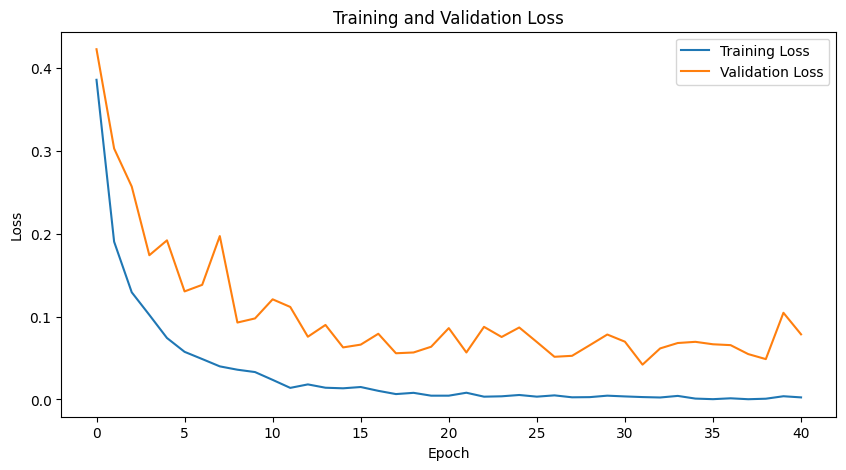

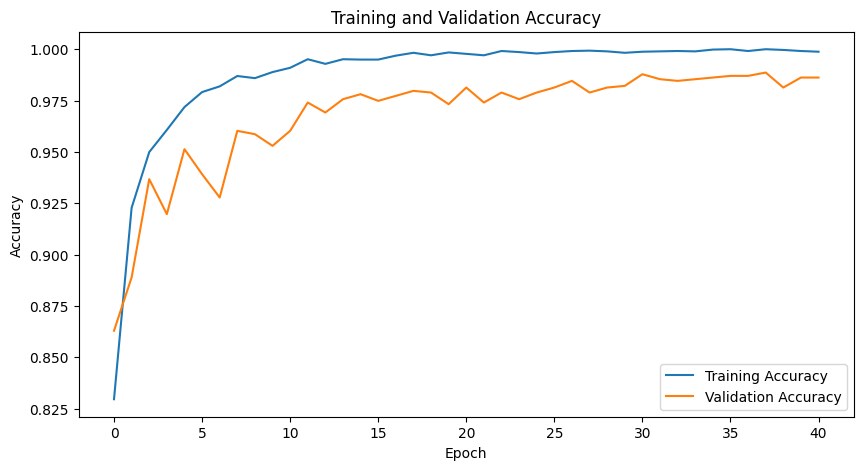

In [6]:
max_loss_threshold = 2.0
min_accuracy_threshold = 0.8

filtered_train_loss = [v for v in history.history['loss'] if v <= max_loss_threshold]
filtered_val_loss = [v for v in history.history['val_loss'] if v <= max_loss_threshold]

filtered_train_accuracy = [v for v in history.history['accuracy'] if v >= min_accuracy_threshold]
filtered_val_accuracy = [v for v in history.history['val_accuracy'] if v >= min_accuracy_threshold]

min_len = min(len(filtered_train_loss), len(filtered_val_loss), len(filtered_train_accuracy), len(filtered_val_accuracy))
filtered_train_loss = filtered_train_loss[:min_len]
filtered_val_loss = filtered_val_loss[:min_len]
filtered_train_accuracy = filtered_train_accuracy[:min_len]
filtered_val_accuracy = filtered_val_accuracy[:min_len]

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_loss, label='Training Loss')
plt.plot(filtered_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(filtered_train_accuracy, label='Training Accuracy')
plt.plot(filtered_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
model.load_weights('best_weights.weights.h5')
print('Loaded')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
print('converter initialized')

tflite_model = converter.convert()
print('converted')

with open('/kaggle/working/model_1.tflite', 'wb') as f:
    f.write(tflite_model)
    print('written')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Loaded
converter initialized
